In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline


from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
data = Path().absolute()/'data'

## Importando citações

In [3]:
moral_df = pd.read_csv(data/'citacoes_moralidade.csv')

Removendo citaçoes sobre Sumulas

In [4]:
moral_df.query('~caso.str.contains("sumula")', engine='python', inplace=True)

## Importando dados do grafo

In [5]:
moral_graph = nx.read_graphml(str(data.parent/'grafo_moralidade.graphml'))

### Gerando gráficos com distribuição de nós 

In Degree

In [6]:
in_degree = pd.Series(dict(moral_graph.in_degree), name='Número de Citações Recebidas').reset_index()

In [7]:
in_d_dist = in_degree.groupby('Número de Citações Recebidas').index.nunique().reset_index()

in_d_dist.rename(columns={'index': 'Número de Casos'}, inplace=True)

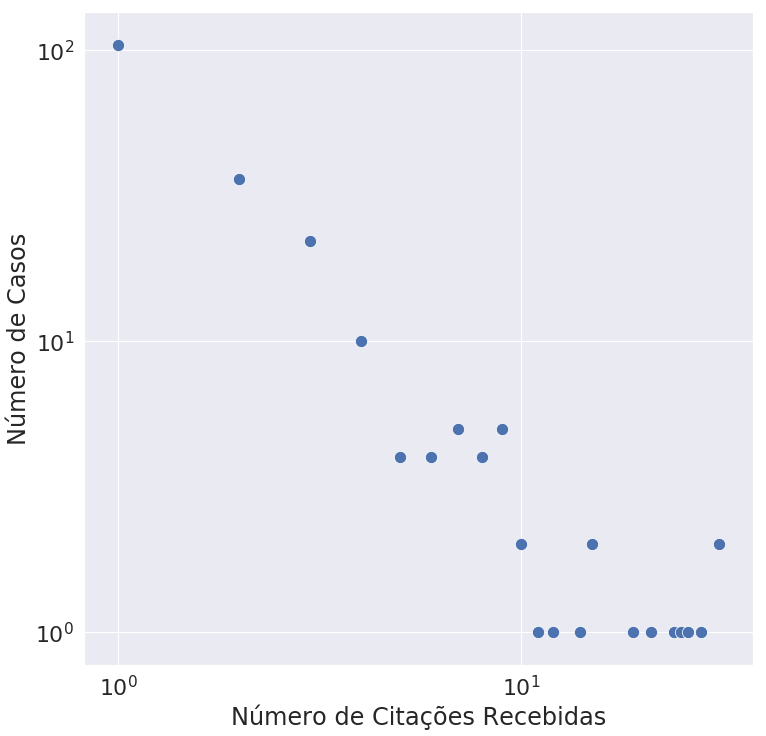

In [8]:
sns.set(rc={'figure.figsize':(12,12)}, font_scale=2)

fig, ax = plt.subplots(figsize=(12,12))

plt.xscale('log')
plt.yscale('log')

in_degree_graph = sns.scatterplot(x='Número de Citações Recebidas', y='Número de Casos', data=in_d_dist.drop(0), s=150,)

In [9]:
fig.savefig('graficos/in_moralidade.png')

Out Degree

In [10]:
out_degree = pd.Series(dict(moral_graph.out_degree), name='Número de Citações Realizadas').reset_index()

In [11]:
out_d_dist = out_degree.groupby('Número de Citações Realizadas').index.nunique().reset_index()

out_d_dist.rename(columns={'index': 'Número de Casos'}, inplace=True)

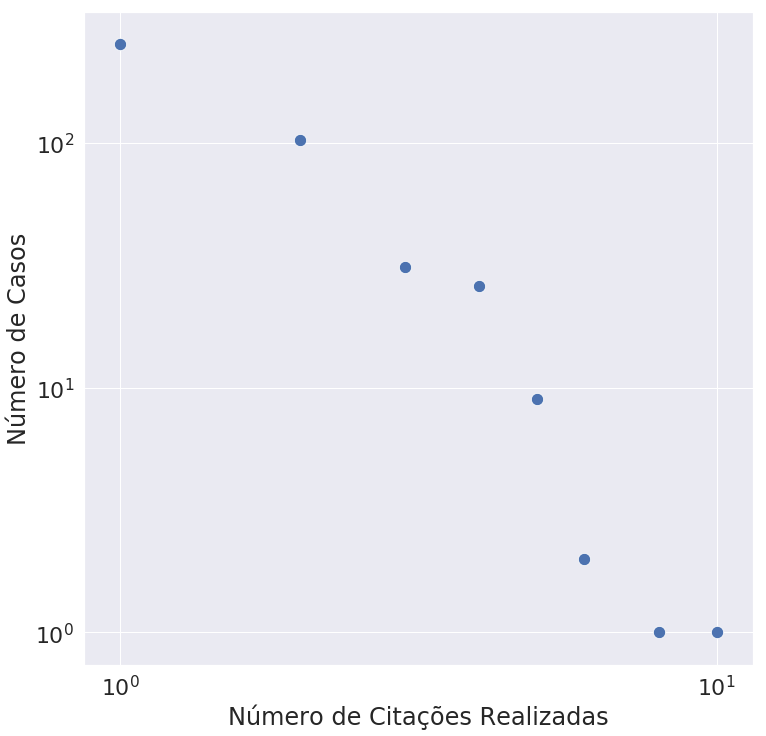

In [12]:
sns.set(rc={'figure.figsize':(12,12)}, font_scale=2)

fig, ax = plt.subplots(figsize=(12,12))

plt.xscale('log')
plt.yscale('log')

in_degree_graph = sns.scatterplot(x='Número de Citações Realizadas', y='Número de Casos', data=out_d_dist.drop(0), s=150,)

In [13]:
fig.savefig('graficos/out_moralidade.png')

Calculando Page Rank e HITS

In [14]:
pr_m = pd.Series(nx.algorithms.link_analysis.pagerank(moral_graph), name='page_rank').to_frame()

In [15]:
hub, auth = nx.algorithms.link_analysis.hits(moral_graph)

In [16]:
nd = moral_graph.nodes

Identificando comunidades por modularidade

In [17]:
mod_m = pd.Series(nx.get_node_attributes(moral_graph, 'Modularity Class'),
                  name='modularity').to_frame()

Calculando atributos dos casos

In [18]:
hub_m = pd.Series(hub, name='hub_score').to_frame()

auth_m = pd.Series(auth, name='auth_score').to_frame()

In [19]:
moral_info = pr_m.join(auth_m).join(hub_m)

#### obtaining cases that were both cited and present on the network

In [20]:
moral_info.index.name = 'caso'
moral_info.reset_index(drop=False, inplace=True)
moral_info['caso'] = moral_info.caso.str.lower()

In [21]:
moral_df = moral_df.merge(moral_info, how='left')

In [22]:
moral_df.set_index('caso', inplace=True)

# Regressão - Não utilizada 

Regressão não foi utilizada devido a haverem poucas observações

Creating series for linear regression

In [23]:
y_m1 = moral_df.dropna(subset=['page_rank']).page_rank
y_m2 = moral_df.dropna(subset=['page_rank']).auth_score

In [24]:
x_m_citado = moral_df.dropna(subset=['page_rank']).citado

x_m_n_cit = moral_df.dropna(subset=['page_rank']).citacoes_total

In [25]:
linmodel_m_pr = sm.OLS(y_m1, x_m_n_cit).fit()
linmodel_m_pr.summary()

/usr/local/lib/python3.5/dist-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              page_rank   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     9.780
Date:                Tue, 20 Nov 2018   Prob (F-statistic):             0.0353
Time:                        18:27:34   Log-Likelihood:                 17.620
No. Observations:                   5   AIC:                            -33.24
Df Residuals:                       4   BIC:                            -33.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
citacoes_total     0.0041      0.001      3.127      0.035       0.000       0.008
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.377
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.558
Skew:                           0.022   Prob(JB):                        0.756
Kurtosis:                       1.363   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
linmodel_m_auth = sm.OLS(y_m2, x_m_n_cit).fit()
linmodel_m_auth.summary()

/usr/local/lib/python3.5/dist-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             auth_score   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     4.034
Date:                Tue, 20 Nov 2018   Prob (F-statistic):              0.115
Time:                        18:27:34   Log-Likelihood:                 3.7023
No. Observations:                   5   AIC:                            -5.405
Df Residuals:                       4   BIC:                            -5.795
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
citacoes_total     0.0426      0.021      2.009      0.115      -0.016       0.101
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.344
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.193
Skew:                          -0.378   Prob(JB):                        0.908
Kurtosis:                       2.404   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


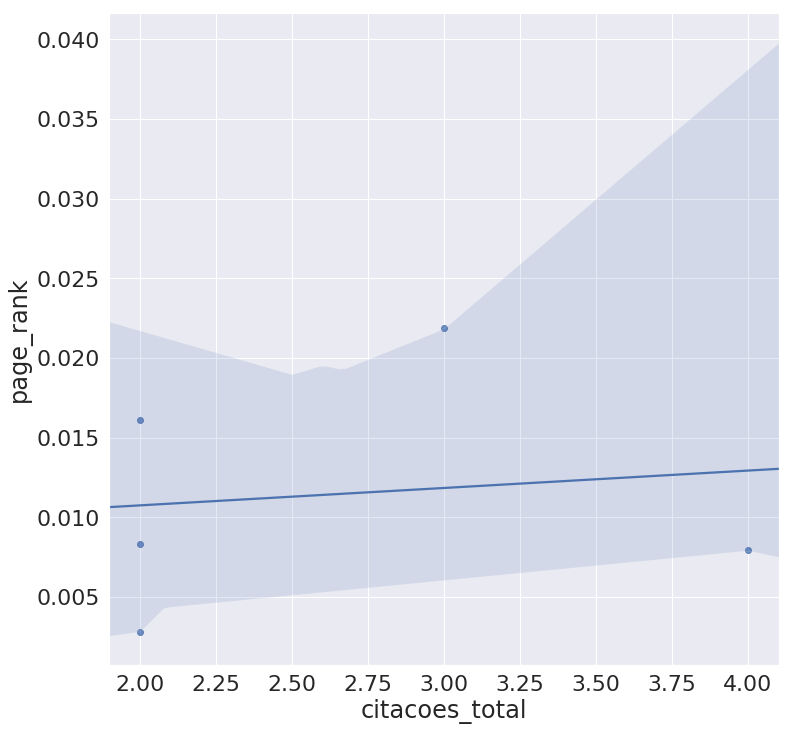

In [27]:
sns.regplot(x='citacoes_total', y='page_rank', data=moral_df)